In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import bz2

In [3]:
def labels_text(x):
  label=[]
  text=[]
  for line in bz2.BZ2File(x):
    decode = line.decode("utf-8")
    label.append(int(decode[9]) - 1)
    text.append(decode[10:].strip())
  return np.array(label),text

#Reading the datasets

train_label, train_text = labels_text('drive/MyDrive/NLP-Project/amazonreviews/train.ft.txt.bz2')
test_label, test_text = labels_text('drive/MyDrive/NLP-Project/amazonreviews/test.ft.txt.bz2')

In [4]:
#Shuffling the dataset as we will use a part of it
from sklearn.utils import shuffle
train_text, train_label = shuffle(train_text, train_label)
test_text, test_label = shuffle(test_text, test_label)

In [5]:
train_text[0]

'Informative: Lee Strobel presented a compelling case for the historical and logical foundation of Christianity.'

In [6]:
train_label[0]

1

In [7]:
len(train_text)

3600000

In [8]:
len(test_text)

400000

In [9]:
#10000 reviews for training
train_text=train_text[0:10000]
train_label=train_label[0:10000]

In [10]:
#2500 reviews for testing
test_text=test_text[0:2500]
test_label=test_label[0:2500]

In [11]:
!sudo apt-get install swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [12]:
!sudo pip install jamspell

In [13]:
!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz

--2021-06-14 08:45:53--  https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz [following]
--2021-06-14 08:45:53--  https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36611828 (35M) [application/octet-stream]
Saving to: ‘en.tar.gz.2’

en.tar.gz.2         100%[===================>]  34.92M  33.6MB/s    in 1.0s    

2021-06-14 08:45:55 (33.6 MB/s) - ‘en.tar.gz.2’ saved [36611828/36611828]



In [14]:
!tar -xvf en.tar.gz

en.bin


In [15]:
#For spelling correction with context
import jamspell

In [16]:
#initializing spelling corrector
jsp = jamspell.TSpellCorrector()
assert jsp.LoadLangModel('en.bin')

In [17]:
jsp.FixFragment("Everyone just wants pece in their life")

'Everyone just wants peace in their life'

In [18]:
jsp.FixFragment("I ate a pece of chicken")

'I ate a piece of chicken'

In [19]:
#Applying spelling correction to training dataset
for i in range(10000):
  train_text[i] = jsp.FixFragment(train_text[i])

In [20]:
#Preprocessing
import re 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus_train=[]

for i in range(10000):
    review = re.sub('".*?"', '', train_text[i]) #removing any word within quotation marks
    review = re.sub('[^a-zA-Z]', ' ', review) #keeping only letters and removing anything else
    review = review.lower() #converting everything to lowercase
    review = review.split() #splitting each word in string and placing it into a list
    # ps = PorterStemmer() #stemming
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not') #keeping not as it is essential for sentiment analysis
    # review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review) #forming a string form a splitted list of words
    corpus_train.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
len(corpus_train)

10000

In [22]:
corpus_test=[]
for i in range(2500):
    review2 = re.sub('".*?"', '', test_text[i]) #removing any word within quotation marks
    review2 = re.sub('[^a-zA-Z]', ' ', review2) #keeping only letters and removing anything else
    review2 = review2.lower() #converting everything to lowercase
    review2 = review2.split() #splitting each word in string and placing it into a list
    # ps = PorterStemmer() #stemming
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not') #keeping not as it is essential for sentiment analysis
    # review2 = [ps.stem(word) for word in review2 if not word in set(all_stopwords)]
    review2 = ' '.join(review2) #forming a string form a splitted list of words
    corpus_test.append(review2)

In [23]:
print(corpus_test[0])

uhhhhh when i first heard this album it was garbage now im in to hip hop like krs one tribe called quest kweli but this album is completely lacking tight lyrics or beats please dont buy this album unless you are collecting lol


In [24]:
print(corpus_train[0])

informative lee strobel presented a compelling case for the historical and logical foundation of christianity


In [25]:
#Vectorizing 
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(use_idf=False, norm=None, ngram_range=(1, 2),min_df=1,max_df=0.5)
X = cv.fit_transform(corpus_train)
y = train_label[0:10000]

In [26]:
#Setting up our X_train, X_val, y_train, y_val 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [27]:
#importing essential libraries
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
#First model for ensemble
clf1 = RandomForestClassifier(n_estimators = 100, random_state = 9)

In [29]:
#Second model for ensemble
clf2 = BaggingClassifier(LogisticRegression(max_iter = 10000), max_samples = 0.4, max_features = 1.0,n_estimators = 5, random_state = 2)

In [30]:
#Third model for ensemble
clf3=SVC(kernel='rbf', probability=False, degree = 2, random_state = 3, C = 3)

In [31]:
#Fourth model for ensemble
clf4 = DecisionTreeClassifier()

In [32]:
#Using Voting Classifier for ensemble learning
eclf1 = VotingClassifier(estimators=[('rf',clf1), ('sgd', clf2), ('svm', clf3), ('dt',clf4)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)

In [33]:
#Results Validation
print(eclf1.score(X_train,y_train))
y_pr = eclf1.predict(X_val)
acc=accuracy_score(y_val,y_pr)
f1score=f1_score(y_val,y_pr,average='macro')
print("Accuracy:",acc)
print("f1 Score:",f1score)
print(classification_report(y_val,y_pr))

1.0
Accuracy: 0.8628
f1 Score: 0.8627962900116819
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1199
           1       0.90      0.82      0.86      1301

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.87      0.86      0.86      2500



In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(use_idf=False, norm=None, ngram_range=(1, 2),min_df=1,max_df=0.5)

train_vector=cv.fit_transform(corpus_train)
test_vector=cv.transform(corpus_test)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

xTrain=train_vector
yTrain=train_label
xTest=test_vector
yTest=test_label
# xTrain.shape
print(len(yTrain))

10000


In [36]:
eclf2 = VotingClassifier(estimators=[('rf',clf1), ('sgd', clf2), ('svm', clf3), ('dt',clf4)], voting='hard')
eclf2 = eclf2.fit(xTrain, yTrain)

In [38]:
#Results testing
print(eclf2.score(xTrain,yTrain))
y_pred = eclf2.predict(xTest)
acc=accuracy_score(yTest,y_pred)
f1score=f1_score(yTest,y_pred,average='macro')
print("Accuracy:",acc)
print("f1 Score:",f1score)
print(classification_report(yTest,y_pred))

0.9998
Accuracy: 0.8632
f1 Score: 0.8628404444547115
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1281
           1       0.88      0.83      0.86      1219

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



In [39]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

conmat = np.array(confusion_matrix(yTest, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['True Positive', 'True Negative'],
                         columns=['Predicted Positive','Predicted Negative'])


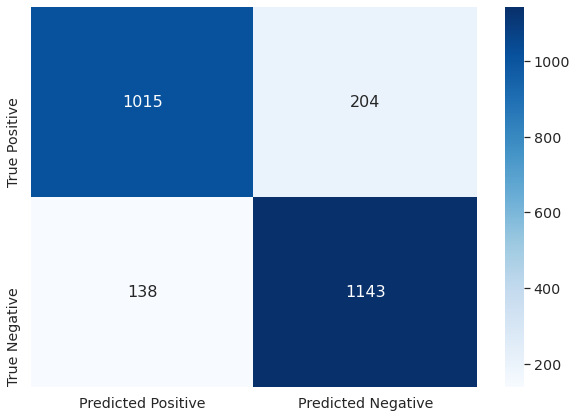

In [40]:
#Plotting the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sn.set(font_scale=1.3)
sn.heatmap(confusion, annot=True, annot_kws={"size": 16},fmt='g',cmap='Blues')
plt.show()